In [16]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

from collections import OrderedDict, namedtuple

import numpy as np
import scipy.stats
import pystan
import elfi

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import logging
logging.basicConfig(level=logging.INFO)

# Arbitrary seed for reproducibility
seed = 20170533
np.random.seed(seed)

# Requirements
# statsmodels 0.8.0, pandas 0.23.2, matplotlib 2.1.1, pystan 2.19.1.1

# Utilities: auxiliary functions

In [17]:
# constants
J = 12 # number of individual analyses
n_obs = 10 # number of observations per analysis

# Define the MA(2) simulator
def MA2(theta1, theta2, n_obs=n_obs, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    theta1 = np.asanyarray(theta1).reshape((-1, 1))
    theta2 = np.asanyarray(theta2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + theta1*w[:, 1:-1] + theta2*w[:, :-2]
    return x

# Autocovariance for summary statistics
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_theta1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        theta1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return theta1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_theta2(elfi.Distribution):
    def rvs(theta1, a, size=1, random_state=None):
        locs = np.maximum(-a-theta1, theta1-a)
        scales = a - locs
        theta2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return theta2


def extract(results, tstar):
    means = []
    covs = []
    for r in results:
        samples = np.column_stack(tuple(r.samples.values()))
        m = np.mean(samples, axis=0)
        means.append(m)
        cov = np.cov(samples, rowvar=False)
        covs.append(cov)

    means = np.array(means)
    covs = np.array(covs)
    return means, covs



# Independent ABC inferences for the MA(q=2) processes

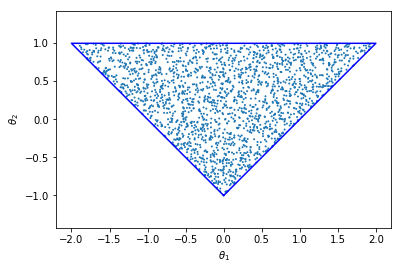

In [18]:
theta1_prior = CustomPrior_theta1.rvs(2, 2000)
theta2_prior = CustomPrior_theta2.rvs(theta1_prior, 1, 2000)
plt.scatter(theta1_prior, theta2_prior, s=4, edgecolor='none');
plt.plot([0, 2, -2, 0], [-1, 1, 1, -1], c='b')  # outlines of the triangle
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.axis('equal')
#plt.gcf().savefig('ma2_prior.eps', format='eps')
plt.show()

In [19]:
# generate J parameters, one for each analysis
theta1_gen = np.random.uniform(0.4, 0.8, size = J)
epsilon = np.random.normal(scale = 0.04, size = J)
theta2_gen = -0.4 + theta1_gen + epsilon

In [ ]:
# compute the mean and covariance of the generated parameters
mean_gen = np.mean(np.stack((theta1_gen,theta2_gen)),axis=1)
cov_gen = np.cov(theta1_gen,theta2_gen)

In [20]:
# Run J ABC inferences
N = 1000 # number of samples
results = []

theta1 = elfi.Prior(CustomPrior_theta1, 2)
theta2 = elfi.Prior(CustomPrior_theta2, theta1, 1)

ys = []

for i in range(J):
    # Take a new model with a different observed data each time
    y_obs = MA2(theta1_gen[i], theta2_gen[i])
    ys.append(y_obs)
    Y = elfi.Simulator(MA2, theta1, theta2, observed=y_obs)
    S1 = elfi.Summary(autocov, Y)
    S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2
    d = elfi.Distance('euclidean', S1, S2)
    r = elfi.Rejection(d, batch_size=10000, seed=seed) # inference algoirthm object
    s = r.sample(N, threshold=.1) # result object
    results.append(s)

Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete
Progress [==================================================] 100.0% Complete


In [21]:
theta_true = np.column_stack((theta1_gen,theta2_gen)) # true generating parameter values
means, covs = extract(results, theta_true) 

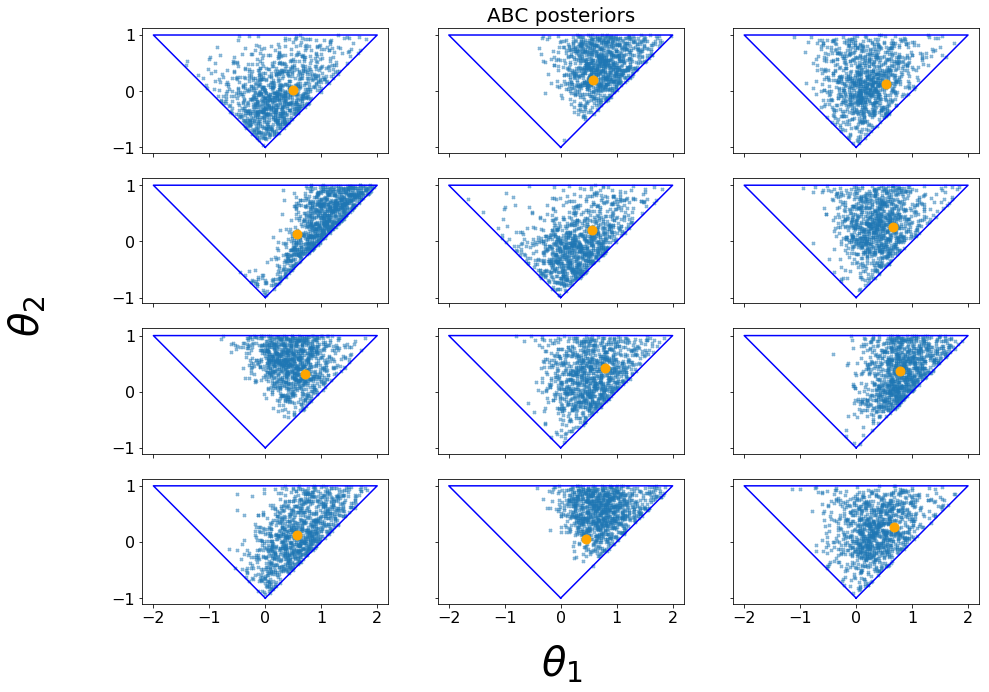

In [22]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

fig, axs = plt.subplots(4,3, figsize=(15, 10), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)

axs = axs.ravel()

for i in range(J):
    axs[i].scatter(results[i].samples['theta1'],results[i].samples['theta2'], s=10, alpha=0.4, marker='X')
    axs[i].scatter(theta1_gen[i],theta2_gen[i], c="orange", s=80) # 45
    axs[i].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle
    
fig.text(0.5135, 0.0, r'$\theta_1$', ha='center', fontsize=40)
fig.text(0.0, 0.5, r'$\theta_2$', va='center', rotation='vertical', fontsize=40)
fig.savefig('independent_posteriors_upd8.pdf', format='pdf')
axs[1].set_title('ABC posteriors',fontsize=20)
plt.show()

# Meta-analysis of Bayesian analyses

In [23]:
efb_model_code = """
data {
    int<lower=0> J; // number of experiments
    int<lower=1> dim;

    // Hyperparameters for multivariate normal prior on prior on mu0
    vector[dim] m;
    cov_matrix[dim] V;    

    // Hyperparameters for inverse-Wishart prior on Sigma0
    real nu; // degrees of freedom, has to be larger than dim-1
    cov_matrix[dim] Psi;

    // Parameters of the J observed individual posteriors over the thetas
    vector[dim] mu[J];
    cov_matrix[dim] Sigma[J]; 
}
parameters {
    // Parameters of the common prior over the thetas (collectively denoted as phi in the paper)
    vector[dim] mu0;
    cov_matrix[dim] Sigma0;

    // Updated posterior samples
    vector[dim] theta[J];
}
model {
    mu0 ~ multi_normal(m, V);
    Sigma0 ~ inv_wishart(nu, Psi);
    theta ~ multi_normal(mu0, Sigma0);
    
    for (i in 1:J) target += multi_normal_lpdf(theta[i] | mu[i], Sigma[i]);
}
"""

# Specify the data block in the Stan model
dim = 2

# Mean vector for prior on mu0
m = np.array([0.5, 0]) # was initially 1/3
#  Covariance matrix for prior on mu0
V = np.array([[.4, 0.05], [0.05, 0.1]])


# Degrees of freedom for prior on Sigma0
nu = dim + 2 # this choice makes the mean of the inverse-Wishart equal to Psi
# Prior mean for Sigma0 (see above)
Psi = np.array([[0.4, 0.1], [0.1, 0.2]])



data = dict(J=J, dim=dim, m=m, V=V, nu=nu, Psi=Psi, mu=means, Sigma=covs)

if 'mba' not in locals():
    efb_model = pystan.StanModel(model_code=efb_model_code, model_name='mba')

fit = efb_model.sampling(data=data, iter=8000)

stan_samples = fit.extract()

phi = stan_samples['mu0']
thetas = stan_samples['theta']
S0 = stan_samples['Sigma0']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL mba_08b544e7251f55d827f26fd3eb0299b0 NOW.


In [ ]:
## SIR

def resample(weights, amount):
    choice = np.random.multinomial(amount, weights)
    N = weights.shape[0]
    new_sample_idx = []
    for i in range(N):
        if choice[i] > 0:
            for j in range(choice[i]):
                new_sample_idx.append(i)
    return new_sample_idx

approx_lprobvals = np.zeros((thetas.shape[0],))
for i in range(thetas.shape[0]):
    for j in range(J):
        approx_lprobvals[i] = approx_lprobvals[i] + scipy.stats.multivariate_normal.logpdf(thetas[i, j, :], mean=means[j], cov=covs[j])

KDE_lprobvals = np.zeros((thetas.shape[0],))
for j in range(J):
    aux_mat = thetas[:, j, :]
    kern =  scipy.stats.gaussian_kde(aux_mat.transpose())
    KDE_lprobvals = KDE_lprobvals + kern.logpdf(aux_mat.transpose())

weights = np.exp(KDE_lprobvals - approx_lprobvals)
weights = weights/np.sum(weights)

nsir=1000
phi_sir = np.zeros( (nsir, phi.shape[1] ) )
S0_sir = np.zeros((nsir, S0.shape[1], S0.shape[2]) )
thetas_sir = np.zeros((nsir, thetas.shape[1], thetas.shape[2]))

print(thetas_sir.shape[0])
sir_samp_idx = resample(weights, nsir)
for i in range(nsir):
    phi_sir[i, :] = phi[sir_samp_idx[i], :]        
    S0_sir[i, :] = S0[sir_samp_idx[i], :]    
    for j in range(J):
        thetas_sir[i, j, :] = thetas[sir_samp_idx[i], j, :]       

1000


## Baselines

In [33]:
# Build a Stan model for "naive" combination of independent posterior means

rema_model_code = """
data {
    int<lower=0> J; // number of experiments
    int<lower=1> dim;

    // Hyperparameters for multivariate normal prior on prior on mu0
    vector[dim] m;
    cov_matrix[dim] V;    

    cov_matrix[dim] SScov[J];

    // Emprirical means of the observed independent posteriors over the thetas
    vector[dim] mu[J];
    
    // Hyperparameters for inverse-Wishart prior on Sigma0
    real nu; // degrees of freedom, has to be larger than dim-1
    cov_matrix[dim] Psi;    
}
parameters {
    // Parameters of the common prior over the thetas (collectively denoted as phi in the paper)
    vector[dim] mu0;
    vector[dim] theta[J];
    cov_matrix[dim] Sigma0;    
}
model {
    mu0 ~ multi_normal(m, V);
    Sigma0 ~ inv_wishart(nu, Psi);
    theta ~ multi_normal(mu0, Sigma0);
    for (i in 1:J) 
      mu[i] ~ multi_normal(theta[i], SScov[i]);
}
"""

In [34]:
from statsmodels.tsa.arima_model import ARMA

effects = []
study_covs = []
for j in range(0, J):
    yp = ys[j]
    aux = np.zeros((2,))
#     aux[0] = autocov(yp)
#     aux[1] = autocov(yp, 2)


    
    aux[1] =  autocov(yp, 2) 
    aux[0] =  autocov(yp) / (1 + aux[1]) 
    
    
    yaux = np.reshape(yp, (10,))
    model = ARMA(yaux, order=(0, 2)) # AR order 0, MA order 2
    model_fit = model.fit(start_params=aux, trend='nc', solver='cg',method='css', tol=1e-16, transparams=False)
    
    
    aux[0] = model_fit.params[0]
    aux[1] = model_fit.params[1]
    
    effects.append(aux)
    btrap = np.zeros((yp.shape[1], 2))
    for n in range(0, yp.shape[1]):
        yaux = yp
        yaux = np.delete(yaux, n)
        yaux = np.reshape(yaux, (1, yp.shape[1] - 1))
        fff = np.zeros((2,))
#         btrap[n, 0] = autocov(yaux)
#         btrap[n, 1] = autocov(yaux, 2)

        btrap[n, 1] =  autocov(yaux, 2)
        btrap[n, 0] =  autocov(yaux) / (1 + btrap[n, 1])

        yaux2 = np.reshape(yaux, (9,))
        model = ARMA(yaux2, order=(0, 2)) # AR order 0, MA order 2
        model_fit = model.fit(start_params=btrap[n,:], trend='nc', solver='cg',method='css', tol=1e-16, transparams=False)

        btrap[n,0] = model_fit.params[0]
        btrap[n,1] = model_fit.params[1]
        
    aco = np.cov(btrap, rowvar=False)
    print(btrap[n,:])
    print(aco)
    study_covs.append(aco)

 /home/diego/anaconda3/envs/MBA/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


Optimization terminated successfully.
         Current function value: 1.169093
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.200856
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.160763
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.122869
         Iterations: 6
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 1.184710
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.884800
         Iterations: 7
         Function evaluations: 13
         Gradien

In [35]:
if 'rema' not in locals():
    naive_model = pystan.StanModel(model_name='rema', model_code=rema_model_code)
dt = dict(J=J, dim=dim, m=m, V=V,  SScov=study_covs, mu=effects, nu=nu, Psi=Psi)    
fit2 = naive_model.sampling(data=dt, iter=4000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rema_9c8dd2643f8e366001c351b7e73ea06b NOW.


In [37]:
stan_samples2 = fit2.extract()

In [38]:
markers = np.zeros((stan_samples2['theta'].shape[0], ), dtype=bool)
for idx in range(0, J):
    Th = stan_samples2['theta']
    Rr = Th[:, idx, :]

    iax = np.logical_or( (Rr[:, 1] > 1) , (Rr[:, 0] > (Rr[:, 1] + 1) ) )
    iax = np.logical_or( iax, (Rr[:,0] + Rr[:,1] < - 1 ) )
    markers = np.logical_or(markers, iax)

markers = np.logical_not(markers)
global_rema = stan_samples2['mu0'];
global_rema = global_rema[markers, :];

(890, 2)


# Local effects

Text(0,0.5,'$\\theta_2$')

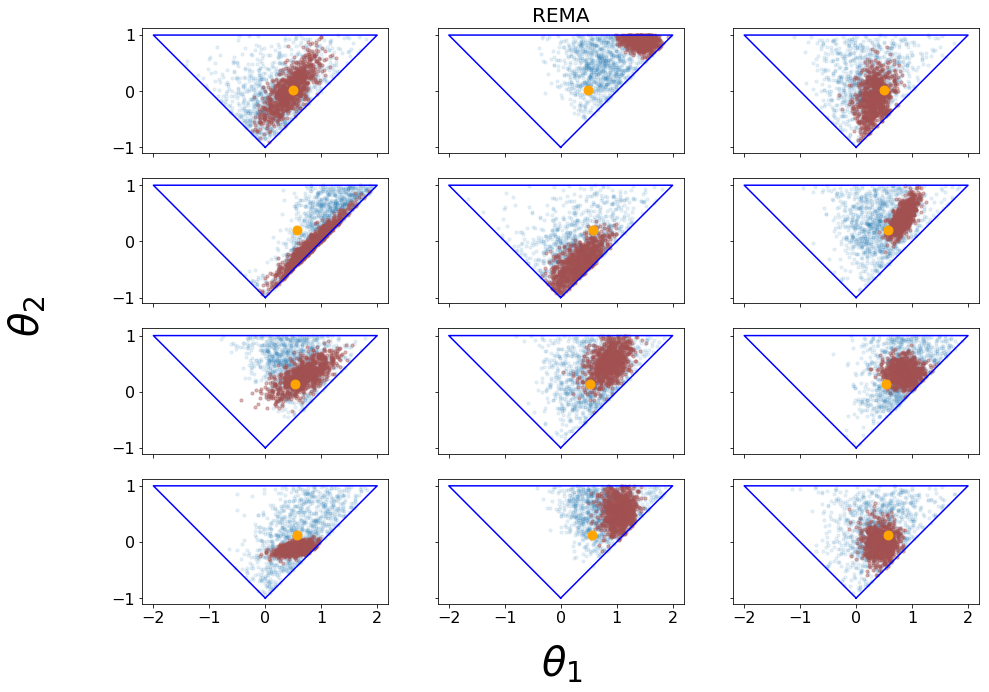

In [42]:
fig, axes = plt.subplots(4,3, figsize=(15, 10), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)

for idx in range(0, J):
    Th = stan_samples2['theta']
    Rr = Th[:, idx, :]
    Rr = Rr[markers, :]
    
    Rold = results[idx]
    
    
    
        
    i = np.floor(idx/3)
    j = idx - i*3
    i = i.astype(int)
    j = j.astype(int)

    axes[i,j].scatter(Rold.samples['theta1'],Rold.samples['theta2'], s=10, alpha=0.1)
    axes[i,j].scatter(Rr[:,0], Rr[:,1], s=10, color="#A25050", alpha=0.4)
    
    axes[i,j].scatter(theta1_gen[i],theta2_gen[i], c="orange", marker='o', s=80)
    axes[i,j].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle
#     axes[i,j].set_ylim((-1.1, 1.4))
#     axes[i,j].set_xlim((-2.1, 2.1))
    axes[i,j].axis('equal')

    
axes[0, 1].set_title('REMA', fontsize=20)
fig.text(0.5135, 0.0, r'$\theta_1$', ha='center', fontsize=40)
fig.text(0.0, 0.5, r'$\theta_2$', va='center', rotation='vertical', fontsize=40)
# fig.tight_layout()

Text(0,0.5,'$\\theta_2$')

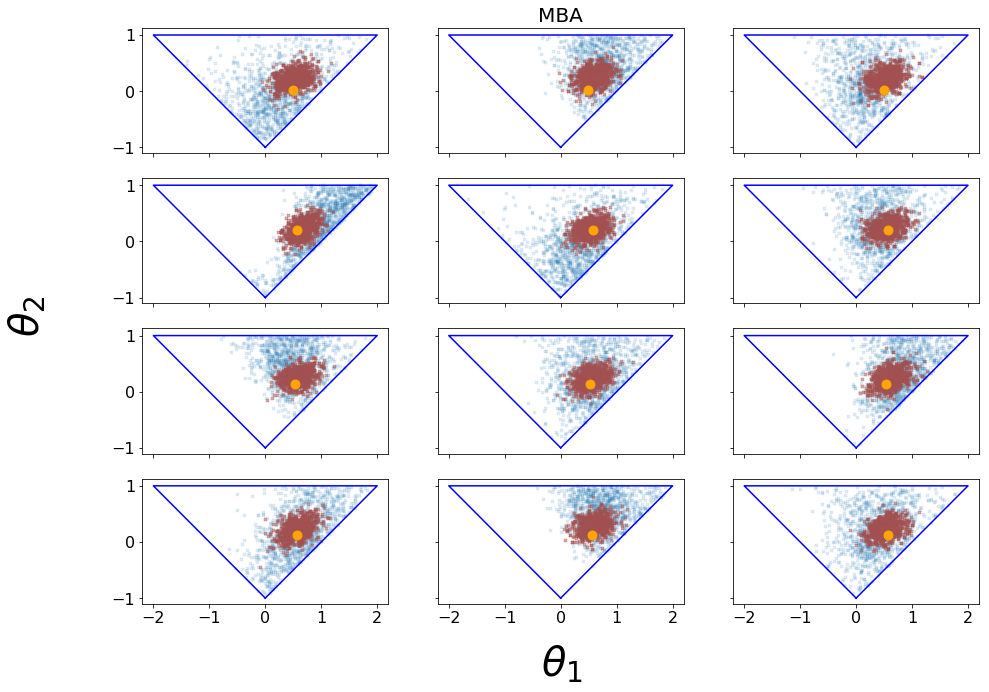

In [44]:
fig, axes = plt.subplots(4,3, figsize=(15, 10), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)

for idx in range(0, J):
    R1 = thetas[:, idx, 0]
    R0 = thetas[:, idx, 1]    
    
    Th = stan_samples2['theta']
    Rr = Th[:, idx, :]

    iax = np.logical_or( (Rr[:, 1] > 1) , (Rr[:, 0] > (Rr[:, 1] + 1) ) )
    Rr = Rr[np.logical_not(iax), :]    
    
    t1sir = thetas_sir[:, idx, 0]
    t2sir = thetas_sir[:, idx, 1]
    
    Rold = results[idx]
        
        
    i = np.floor(idx/3)
    j = idx - i*3
    i = i.astype(int)
    j = j.astype(int)

    axes[i,j].scatter(Rold.samples['theta1'],Rold.samples['theta2'], marker='X', s=10, alpha=0.1)
#     axes[i,j].scatter(Rr[:,0], Rr[:,1], marker='X', s=0.5, color="#A25050", alpha=0.5)
    axes[i,j].scatter(t1sir, t2sir, marker='X', s=10, color="#A25050", alpha=0.4)
    # marker='.', s=30, alpha=0.2
    
    
    axes[i,j].scatter(theta1_gen[i],theta2_gen[i], c="orange", s=80, marker='o')
    axes[i,j].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle
    axes[i,j].axis('equal')
    
axes[0, 1].set_title('MBA', fontsize=20)
fig.text(0.5135, 0.0, r'$\theta_1$', ha='center', fontsize=40)
fig.text(0.0, 0.5, r'$\theta_2$', va='center', rotation='vertical', fontsize=40)
# fig.tight_layout()

## Global effects

In [45]:
phi_re = stan_samples2['mu0']

# Build a Stan model for "naive" combination of independent posterior means
delta_model_code = """
data {
    int<lower=0> J; // number of experiments
    int<lower=1> dim;

    // Hyperparameters for multivariate normal prior on prior on mu0
    vector[dim] m;
    cov_matrix[dim] V;    

    // Hyperparameters for the inverse-Wishart
    real nu; // degrees of freedom, has to be larger than dim-1
    cov_matrix[dim] Psi;

    // Emprirical means of the observed independent posteriors over the thetas
    vector[dim] mu[J];
}
parameters {
    // Parameters of the common prior over the thetas (collectively denoted as phi in the paper)
    vector[dim] mu0;
    cov_matrix[dim] Sigma0;
}
model {
    mu0 ~ multi_normal(m, V);
    Sigma0 ~ inv_wishart(nu, Psi);
    for (i in 1:J) 
      mu[i] ~ multi_normal(mu0, Sigma0);
}
"""

In [46]:
if 'delta' not in locals():
    delta_model = pystan.StanModel(model_name='delta', model_code=delta_model_code)
dt = dict(J=J, dim=dim, m=m, V=V,   mu=effects, nu=nu, Psi=Psi)    
fit3 = delta_model.sampling(data=data, iter=500)
stan_samples3 = fit3.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL delta_90ebb53009015e229b3c6598c931ae62 NOW.


In [47]:
# Build a Stan model for "naive" combination of independent posterior means

fixed_effects_code = """
data {
    int<lower=0> J; // number of experiments
    int<lower=1> dim;

    // Hyperparameters for multivariate normal prior on prior on mu0
    vector[dim] m;
    cov_matrix[dim] V;    

    cov_matrix[dim] SScov[J];

    // Emprirical means of the observed independent posteriors over the thetas
    vector[dim] mu[J];    
}
parameters {
    // Parameters of the common prior over the thetas (collectively denoted as phi in the paper)
    vector[dim] mu0; 
}
model {
    mu0 ~ multi_normal(m, V);
    for (i in 1:J) 
      mu[i] ~ multi_normal(mu0, SScov[i]);
}
"""

if 'fixed' not in locals():
    fe_model = pystan.StanModel(model_name='fixed', model_code=fixed_effects_code)

dt = dict(J=J, dim=dim, m=m, V=V,   SScov=study_covs, mu=effects)    
fit4 = fe_model.sampling(data=dt, iter=500)
stan_samples4 = fit4.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL fixed_76ac467ac3d3210c2258638dc0393a33 NOW.


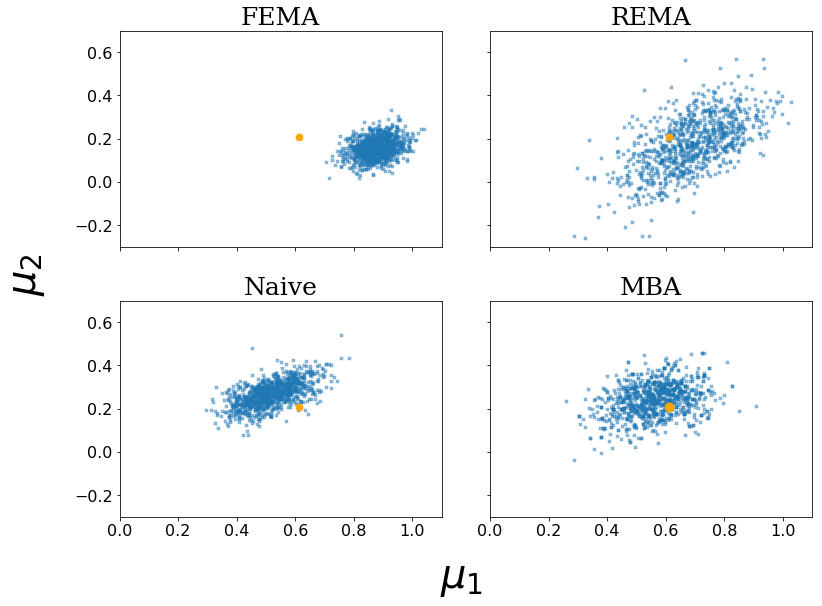

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex='col', sharey='row')
fig.subplots_adjust(left  = 0.16, right = 0.9, bottom = 0.15, top = 0.9, wspace = 0.15, hspace = 0.25)

axs = axs.ravel()

axs[0].scatter(stan_samples4['mu0'][:,0],stan_samples4['mu0'][:,1], s=10, alpha=0.4, marker='X')
axs[0].scatter(mean_gen[0],  mean_gen[1], c="orange", marker='o', s=45 )
# axs[0].scatter(np.mean(stan_samples4['mu0'][:,0]), np.mean(stan_samples4['mu0'][:,1]), c='r',  alpha=1)
axs[0].title.set_text('FEMA')
axs[0].title.set_fontsize(25)
axs[0].title.set_fontname('serif')
axs[0].set_xlim((0.0, 1.1))
axs[0].set_ylim((-0.3, 0.7))

axs[1].scatter(global_rema[:,0],global_rema[:,1],s=10, alpha=0.4, marker='X')
axs[1].scatter(mean_gen[0],  mean_gen[1],c="orange", marker='o', s=45 )
# axs[1].scatter(np.mean(stan_samples2['mu0'][:,0]), np.mean(stan_samples2['mu0'][:,1]), c='r',  alpha=1)
axs[1].title.set_text('REMA')
axs[1].title.set_fontsize(25)
axs[1].title.set_fontname('serif')
axs[1].set_xlim((0.0, 1.1))
axs[1].set_ylim((-0.3, 0.7))

axs[2].scatter(stan_samples3['mu0'][:,0],stan_samples3['mu0'][:,1], s=10, alpha=0.4, marker='X')
axs[2].scatter(mean_gen[0],  mean_gen[1],c="orange", marker='o', s=45 )
# axs[2].scatter(np.mean(stan_samples3['mu0'][:,0]), np.mean(stan_samples3['mu0'][:,1]), c='r', alpha=1)
axs[2].title.set_text('Naive')
axs[2].title.set_fontsize(25)
axs[2].title.set_fontname('serif')
axs[2].set_ylim((-0.3, 0.7))
axs[2].set_xlim((0.0, 1.1))



axs[3].scatter(phi_sir[:,0], phi_sir[:,1], s=10, alpha=0.4, marker='X')
axs[3].scatter(mean_gen[0],  mean_gen[1], c="orange", marker='o', s=80 )
# axs[3].scatter(np.mean(phi_sir[:,0]), np.mean(phi_sir[:,1]), c='r',  alpha=1)
axs[3].title.set_text(r'MBA')
axs[3].title.set_fontsize(25)
axs[3].title.set_fontname('serif')
axs[3].set_ylim((-0.3, 0.7))
axs[3].set_xlim((0.0, 1.1))

fig.text(0.525, 0.04, r'$\mu_1$', ha='center', fontsize=40)
fig.text(0.04, 0.525, r'$\mu_2$', va='center', rotation='vertical', fontsize=40)

fig.savefig('ma2_true_effect_upd8.pdf', format='pdf')


plt.gcf().savefig('mu0_posteriors_mu_upd8.pdf', format='pdf')
plt.show()
